### Binaryzacja (ang. thresholding)

Operacja punktowa dokonująca konwersji obrazu wielodcieniowego do postaci obrazu binarnego (dwutonowego). Można wyrżnić binaryzację jednoprogową i jej warianty, binaryzację dwuprogową, binaryzację z histerezą, binaryzację z progiem adaptacyjnym (operacja kontekstowa).

#### Binaryzacja jednoprogowa

Warianty dostepne w bibliotece **OpenCV** są opisane w [dokumentacji](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#gaa9e58d2860d4afa658ef70a9b1115576).

Warianty:
* **THRESH_BINARY**: binaryzacja prosta,
* **THRESH_BINARY_INV**: binaryzacja z inwersją wartości wyjściowych,
* **THRESH_TRUNC**, **THRESH_TOZERO**, **THRESH_TOZERO_INV**: warianty binaryzacji z histerezą.

In [1]:
def show2imgs(im1, im2, title1='Obraz pierwszy', title2='Obraz drugi', size=(10,10)):
    
    import matplotlib.pyplot as plt
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=size)
    ax1.imshow(im1, cmap='gray')
    ax1.axis('off')
    ax1.set_title(title1)

    ax2.imshow(im2, cmap='gray')
    ax2.axis('off')
    ax2.set_title(title2)
    plt.show()

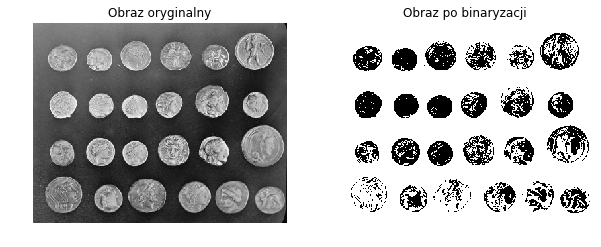

In [8]:
from skimage import data
import cv2

im = data.coins()

th = 150
th, bim = cv2.threshold(im, thresh=th, maxval=255, type=cv2.THRESH_BINARY_INV)

show2imgs(im, bim, title1='Obraz oryginalny', title2='Obraz po binaryzacji', size=(10,10))

#### Binaryzacja adaptacyjna

Próg binaryzacji nie jest ustalony *apriori*, ale wyznaczany na podstawie średniej wartości luminancji punktów sąsiadujących (otoczenia). Funkcji należy przekazać dodatkowe parametry jak **blockSize** oraz <b>C</b>. Operacja binaryzacji może pracować w dwóch trybach: **THRESH_BINARY** lub **THRESH_BINARY_INV**. 

Schemat przekształcenia: $T(i,j) = \mu\Bigl([i,j] \in blockSize \times blockSize\Bigr) - C$, gdzie $\mu$ oznacza średnią artymetyczną. 

Rozmiar otoczenia powinien byc nieparzysty. Dlaczego?


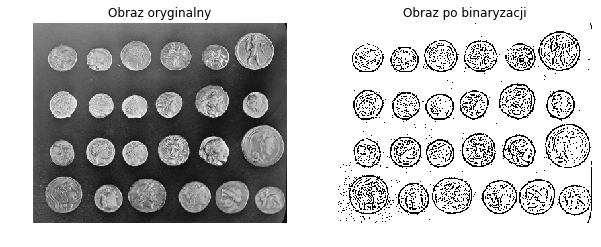

In [9]:
method = cv2.ADAPTIVE_THRESH_MEAN_C
thType = cv2.THRESH_BINARY
block = 5
C = 10
abim = cv2.adaptiveThreshold(im, maxValue=255, adaptiveMethod=method, thresholdType=thType, blockSize=block, C=C)

show2imgs(im, abim, title1='Obraz oryginalny', title2='Obraz po binaryzacji', size=(10,10))

#### Binaryzacja adaptacyjna z jądrem gaussowskim

Schemat przekształcenia analogiczny jak w przypadku binaryzacji adaptacyjnej z tym, że próg binaryzacji jest wyznaczany na podstawie sredniej ważonej wartościami okna gaussowskiego.



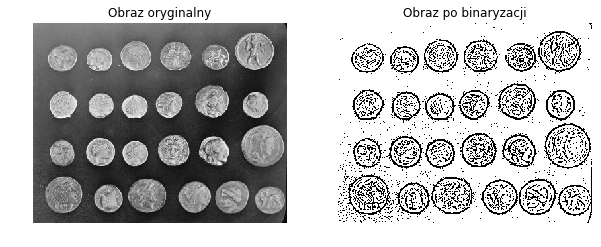

In [13]:
method = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
thType = cv2.THRESH_BINARY
block = 9
C = 7
abim = cv2.adaptiveThreshold(im, maxValue=255, adaptiveMethod=method, thresholdType=thType, blockSize=block, C=C)

show2imgs(im, abim, title1='Obraz oryginalny', title2='Obraz po binaryzacji', size=(10,10))

#### Objaśnienie specyfiki jądra gaussowskiego

## $f(x,y) = A \cdot exp\biggl[{-\Bigl(\frac{(x-\mu_x)^2}{2\sigma_{x}^{2}} + \frac{(y-\mu_y)^2}{2\sigma_{y}^{2}} }\Bigr)\biggr]$



In [5]:
import numpy as np
import scipy.stats as st

def gkernxy(size=(3,3), sigma=(1,1)):
    """Returns a 2D Gaussian kernel array."""

    sigmaX, sigmaY = sigma
    sizeX, sizeY = size
    
    interval = (2*sigmaX+1.)/(sizeX)
    x = np.linspace(-sigmaX-interval/2., sigmaX+interval/2., sizeX+1)
    
    interval = (2*sigmaY+1.)/(sizeY)
    y = np.linspace(-sigmaY-interval/2., sigmaY+interval/2., sizeY+1)
    
    kern1dX = np.diff(st.norm.cdf(x))
    kern1dY = np.diff(st.norm.cdf(y))
    
    kernel_raw = np.sqrt(np.outer(kern1dX, kern1dY))
    kernel = kernel_raw/kernel_raw.sum()
    
    return kernel

In [6]:
kernel = gkernxy((5,5), (.5, 1.))
print((255*kernel).astype(int))

[[ 8 10 11 10  8]
 [ 9 11 11 11  9]
 [ 9 11 12 11  9]
 [ 9 11 11 11  9]
 [ 8 10 11 10  8]]


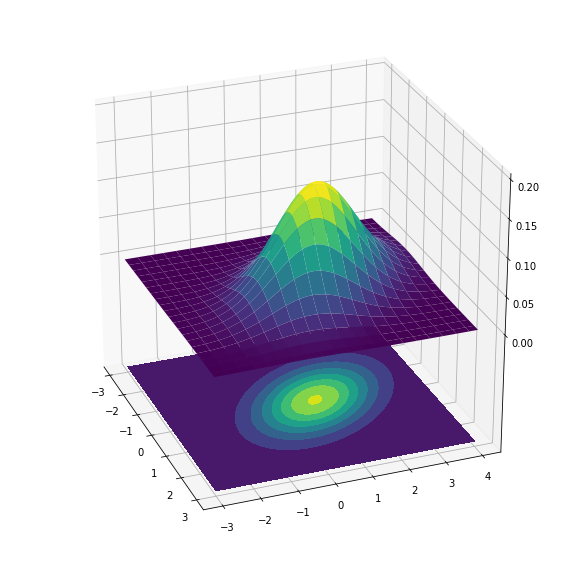

In [7]:
# Author: https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution
# Spligthly modified by marp

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 1.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y


def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N


# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)



# Create a surface plot and projected filled contour plot under it.
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

plt.show()

